In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data Load

In [2]:
import warnings
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

from sqlalchemy import create_engine

from IPython.display import display_html

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

query = """
SELECT *
FROM houseprices
"""

house_prices_df = pd.read_sql_query("SELECT * FROM houseprices", con=engine)

engine.dispose()

<IPython.core.display.Javascript object>

## Helpers

In [3]:
def display_side_by_side(*args):
    html_str = ""
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)


def top_corrs(df, column, n=10):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(10)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()


def na_summary(df, group_col, additional_cols=None):
    if additional_cols is None:
        additional_cols = ["log_saleprice"]

    additional_cols.append(group_col)
    # fmt: off
    df = (
      df[additional_cols]
        .fillna("NaN")
        .groupby(group_col)
        .agg(["size", "mean", "sum"])
    )
    display(df)
    # fmt: on


def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

## General Inspection/Cleaning

In [4]:
print(house_prices_df.shape)
house_prices_df.columns

(1460, 81)


Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

<IPython.core.display.Javascript object>

Use id as index in case theyre important in future, blindly drop NAs from target.

In [5]:
house_prices_df = house_prices_df.set_index("id")
house_prices_df = house_prices_df.dropna(subset=["saleprice"])
house_prices_df.shape

(1460, 80)

<IPython.core.display.Javascript object>

Some columns with almost all missing values.  Investigate potentially dropping.

In [6]:
house_prices_df.isna().mean().sort_values(ascending=False).head(10)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagetype      0.055479
garagecond      0.055479
garagefinish    0.055479
garagequal      0.055479
dtype: float64

<IPython.core.display.Javascript object>

### Inspect target

Target variable has positive skew, investigate a log transform.

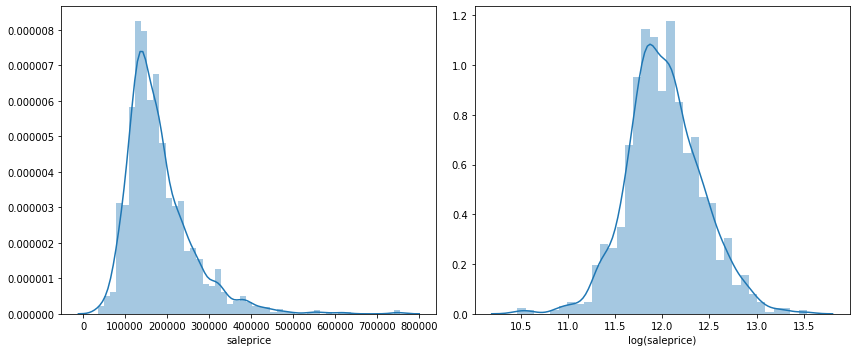

<IPython.core.display.Javascript object>

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(house_prices_df["saleprice"], ax=axes[0])

sns.distplot(np.log(house_prices_df["saleprice"]), ax=axes[1])
axes[1].set_xlabel("log(saleprice)")

plt.tight_layout()
plt.show()

### Correlation analysis

Log sale price appears to improve relationships with all top correlated numeric features.

In [8]:
log_df = house_prices_df.copy()
log_df["log_saleprice"] = np.log(log_df["saleprice"])
log_df = log_df.drop(columns=["saleprice"])

top_n_corrs = top_corrs(house_prices_df, "saleprice")
log_top_n_corrs = top_corrs(log_df, "log_saleprice")

display_side_by_side(top_n_corrs, log_top_n_corrs)

,corr,abs_corr
saleprice,1.000000,1.000000
overallqual,0.790982,0.790982
grlivarea,0.708624,0.708624
garagecars,0.640409,0.640409
garagearea,0.623431,0.623431
totalbsmtsf,0.613581,0.613581
firstflrsf,0.605852,0.605852
fullbath,0.560664,0.560664
totrmsabvgrd,0.533723,0.533723
yearbuilt,0.522897,0.522897


<IPython.core.display.Javascript object>

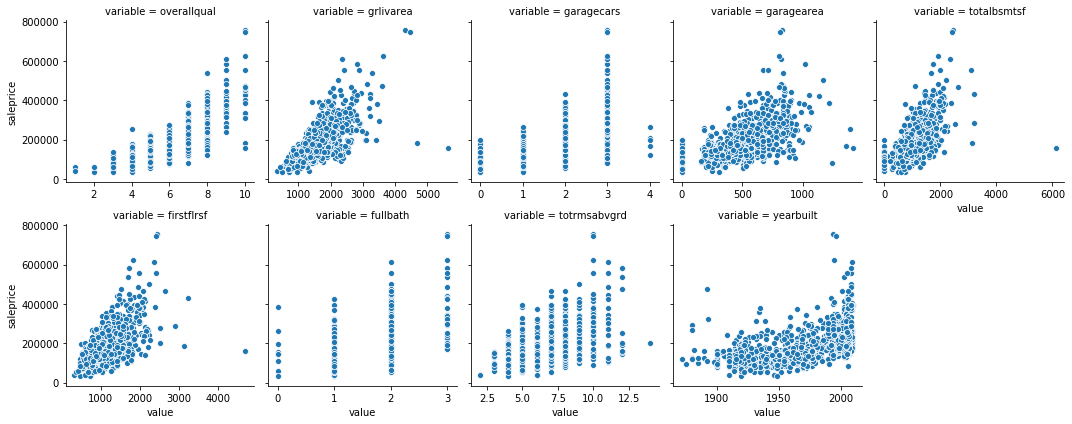

<IPython.core.display.Javascript object>

In [9]:
plot_top_corrs(house_prices_df, "saleprice")

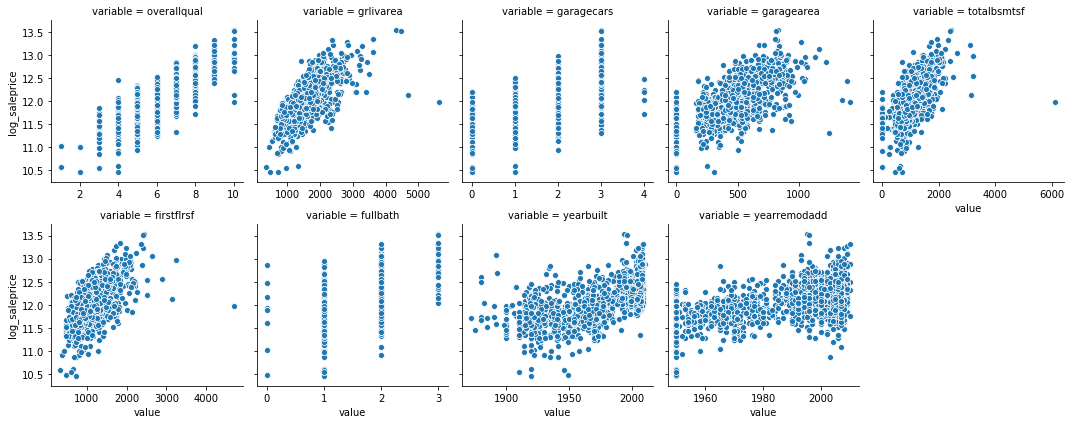

<IPython.core.display.Javascript object>

In [10]:
plot_top_corrs(log_df, "log_saleprice")

From plots there appears to be 1 or more big houses that was sold at a very low price for their features.  See if this is limited to a single observation and drop to avoid affecting fit.

Dropping these observation seems to a good move, this removed high leverage points from a few of these top correlated plots.

In [11]:
drop_ids = log_df.sort_values("firstflrsf", ascending=False).iloc[:4].index
print(f"Dropping house ids {list(drop_ids)}")

Dropping house ids [1299, 497, 524, 1025]


<IPython.core.display.Javascript object>

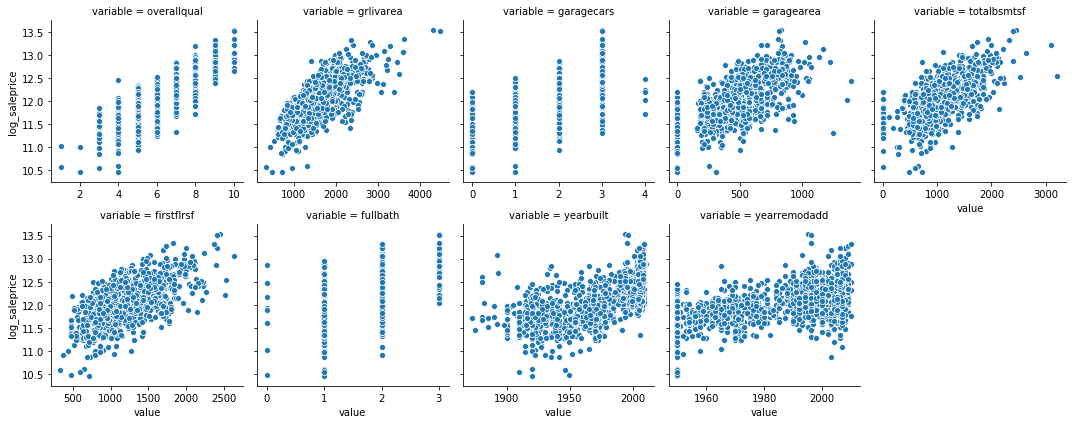

<IPython.core.display.Javascript object>

In [12]:
log_df = log_df.drop(index=drop_ids)
plot_top_corrs(log_df, "log_saleprice")

Moving forward with only top correlated numeric columns.

In [13]:
num_cols = log_df.select_dtypes("number").columns
keep_cols = log_top_n_corrs.index
drop_cols = [c for c in num_cols if c not in keep_cols]
log_df = log_df.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

## Inspect High Missing Columns 
###  To drop or re-encode?

Due to time constraints, I chose to only investigate columns with >10% missing.  Going to drop the rest.

#### poolqc

Idk what `poolqc` is, but this value is only missing when `poolarea` is 0.

There might be a relationship with price, but there's so few observations that it would be tough to learn from reliably.

Strategy: Remove

In [14]:
na_summary(house_prices_df, "poolqc", additional_cols=["poolarea", "saleprice"])

poolarea              saleprice                          
           size   mean   sum      size           mean        sum
poolqc                                                          
Ex            2  533.5  1067         2  490000.000000     980000
Fa            2  583.5  1167         2  215500.000000     431000
Gd            3  598.0  1794         3  201990.000000     605970
NaN        1453    0.0     0      1453  180404.663455  262127976

<IPython.core.display.Javascript object>

#### alley

Similar story to poolqc, alley NAs are valid and indicate that there is no alley.  Seems to have some relationship with price, but not a big enough one to overcome the number of missing values.

Strategy: Remove

In [15]:
na_summary(log_df, "alley")

log_saleprice                         
               size       mean           sum
alley                                       
Grvl             50  11.673354    583.667682
NaN            1365  12.036578  16429.928872
Pave             41  11.996812    491.869296

<IPython.core.display.Javascript object>

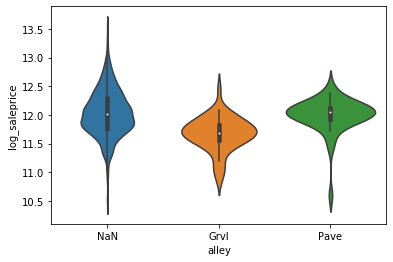

<IPython.core.display.Javascript object>

In [16]:
sns.violinplot("alley", "log_saleprice", data=log_df.fillna("NaN"))
plt.show()

#### miscfeature

Not many observations and doesn't seem to have the biggest effect on price.  Might consider as binary variable if shed had a larger effect on price.

Strategy: Remove

In [17]:
na_summary(log_df, "miscfeature")

log_saleprice                         
                     size       mean           sum
miscfeature                                       
Gar2                    2  12.041560     24.083120
NaN                  1402  12.029022  16864.689363
Othr                    2  11.356596     22.713193
Shed                   49  11.868387    581.550957
TenC                    1  12.429216     12.429216

<IPython.core.display.Javascript object>

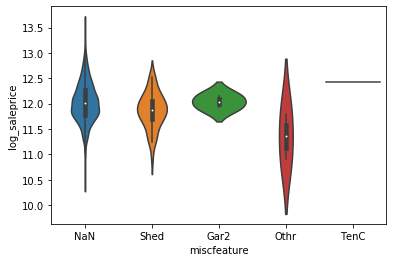

<IPython.core.display.Javascript object>

In [18]:
sns.violinplot("miscfeature", "log_saleprice", data=log_df.fillna("NaN"))
plt.show()

#### fence

same ole, not a big enough effect seen to warrant keeping.

Strategy: Remove

In [19]:
na_summary(log_df, "fence")

log_saleprice                         
               size       mean           sum
fence                                       
GdPrv            59  12.057113    711.369639
GdWo             54  11.784233    636.348590
MnPrv           157  11.850596   1860.543636
MnWw             11  11.796800    129.764805
NaN            1175  12.057395  14167.439180

<IPython.core.display.Javascript object>

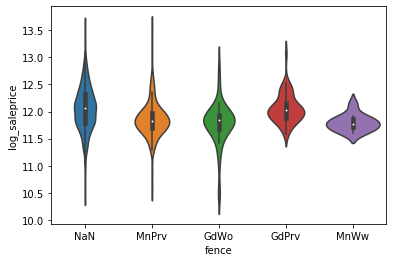

<IPython.core.display.Javascript object>

In [20]:
sns.violinplot("fence", "log_saleprice", data=log_df.fillna("NaN"))
plt.show()

#### fireplacequ

No big effect and there is already a feature indicating number of fireplaces.

Strategy: remove

In [21]:
na_summary(log_df, "fireplacequ")

log_saleprice                        
                     size       mean          sum
fireplacequ                                      
Ex                     24  12.670019   304.080454
Fa                     33  12.008509   396.280812
Gd                    376  12.254878  4607.834162
NaN                   690  11.808907  8148.146033
Po                     20  11.738817   234.776333
TA                    313  12.186416  3814.348056

<IPython.core.display.Javascript object>

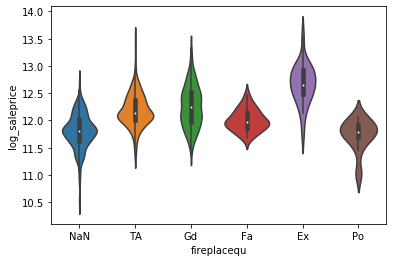

<IPython.core.display.Javascript object>

In [22]:
sns.violinplot("fireplacequ", "log_saleprice", data=log_df.fillna("NaN"))
plt.show()

### Drop NAs from selected cols

In [23]:
drop_cols = ["poolqc", "alley", "fence", "fireplacequ", "miscfeature"]
log_df = log_df.drop(columns=drop_cols)
log_df = log_df.dropna()

print(log_df.shape)
log_df.head()

(1334, 48)


,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,garagetype,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,saletype,salecondition,log_saleprice
id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Attchd,RFn,2,548,TA,TA,Y,WD,Normal,12.247694
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Attchd,RFn,2,460,TA,TA,Y,WD,Normal,12.109011
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Attchd,RFn,2,608,TA,TA,Y,WD,Normal,12.317167
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Detchd,Unf,3,642,TA,TA,Y,WD,Abnorml,11.849398
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Attchd,RFn,3,836,TA,TA,Y,WD,Normal,12.429216


<IPython.core.display.Javascript object>

### Categorical variable analysis

Chuck anova at everything and investigate largest f scores.

After analysis and some arbitrary decisions, going to keep the top 3 'qual' features and the centralair feature.

Strategy:

* ordinal encode qual vars
* binary encode centralair

In [24]:
cat_cols = log_df.select_dtypes("O").copy()
anova_results = []
for col in cat_cols:
    groups = list(log_df[["log_saleprice", col]].groupby(col))
    samples = [group[1]["log_saleprice"] for group in groups]
    f, p = stats.f_oneway(*samples)

    anova_result = {"col": col, "f": f, "p": p}
    anova_results.append(anova_result)

anova_results_df = pd.DataFrame(anova_results).sort_values("f", ascending=False)
top_f = anova_results_df.head(10)
top_f

,col,f,p
17,exterqual,377.740953,2.028969e-177
20,bsmtqual,367.871889,6.259682e-174
29,kitchenqual,357.773677,2.576179e-170
32,garagefinish,308.943586,6.129839e-111
19,foundation,134.678353,1.206424e-96
27,centralair,112.458225,2.795646e-25
26,heatingqc,98.819205,1.103155e-73
16,masvnrtype,97.892638,2.972927e-57
31,garagetype,93.153739,3.450187e-84
0,mszoning,71.513596,6.552679e-55


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


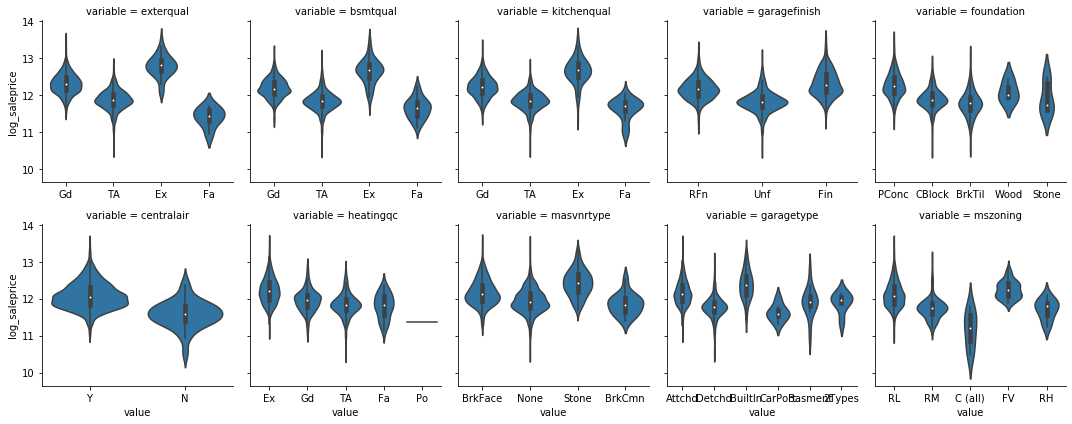

<IPython.core.display.Javascript object>

In [25]:
cat_cols = log_df.select_dtypes("O").copy()[top_f["col"]]
cat_cols["log_saleprice"] = log_df["log_saleprice"]

tall_cat_cols = pd.melt(cat_cols, "log_saleprice")

fg = sns.FacetGrid(tall_cat_cols, col="variable", col_wrap=5, sharex=False)
fg.map(sns.violinplot, "value", "log_saleprice")
plt.show()

Moving forward with `["exterqual", "bsmtqual", "kitchenqual", "centralair"]`, drop all other category columns.

In [26]:
cat_cols = log_df.select_dtypes("O").copy()
keep_cols = ["exterqual", "bsmtqual", "kitchenqual", "centralair"]
drop_cols = [c for c in cat_cols.columns if c not in keep_cols]

log_df = log_df.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

Encode centralair as binary

In [27]:
log_df["centralair"] = (log_df["centralair"] == "Y").astype(int)

<IPython.core.display.Javascript object>

Encode qual columns as ordinal

In [28]:
quality_map = {"Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
log_df[["exterqual", "bsmtqual", "kitchenqual"]] = log_df[
    ["exterqual", "bsmtqual", "kitchenqual"]
].replace(quality_map)

<IPython.core.display.Javascript object>

In [29]:
print(log_df.shape)
log_df.head()

(1334, 14)


,overallqual,yearbuilt,yearremodadd,exterqual,bsmtqual,totalbsmtsf,centralair,firstflrsf,grlivarea,fullbath,kitchenqual,garagecars,garagearea,log_saleprice
id,,,,,,,,,,,,,,
1,7,2003,2003,3,3,856,1,856,1710,2,3,2,548,12.247694
2,6,1976,1976,2,3,1262,1,1262,1262,2,2,2,460,12.109011
3,7,2001,2002,3,3,920,1,920,1786,2,3,2,608,12.317167
4,7,1915,1970,2,2,756,1,961,1717,1,3,3,642,11.849398
5,8,2000,2000,3,3,1145,1,1145,2198,2,3,3,836,12.429216


<IPython.core.display.Javascript object>

## Train Test Split

Some hints of collinearity between square feet variables, going to trudge on.

In [30]:
print_vif(log_df.drop(columns=["log_saleprice"]))

VIF results
-------------------------------
const           26493.563504
overallqual         3.290963
yearbuilt           3.330031
yearremodadd        2.251862
exterqual           2.905071
bsmtqual            2.890810
totalbsmtsf         5.986550
centralair          1.203138
firstflrsf          5.889841
grlivarea           2.683040
fullbath            2.270524
kitchenqual         2.569681
garagecars          4.138833
garagearea          3.590452
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

In [31]:
X = log_df.drop(columns=["log_saleprice"])
y = log_df["log_saleprice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

<IPython.core.display.Javascript object>

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.8627429077819715
test_score: 0.8417400861338824


<IPython.core.display.Javascript object>

Rebuilding with statsmodels for easy access to coefficient info.

In [33]:
X_train_const = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_const).fit()

lm.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     573.4
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:49:17   Log-Likelihood:                 658.37
No. Observations:                1200   AIC:                            -1289.
Df Residuals:                    1186   BIC:                            -1217.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8903      0.663      7.375      0.000       3.589       6.191
overallqual      0.0691      0.006     12.428      0.000       0.058       0.080
yearbuilt        0.0012      0.000      4.925      0.000       0.001       0.002
yearremodadd     0.0016      0.000      5.393      0.000       0.001       0.002
exterqual        0.0133      0.012      1.112      0.266      -0.010       0.037
bsmtqual         0.0395      0.010      3.852      0.000       0.019       0.060
totalbsmtsf      0.0001   2.68e-05      5.552      0.000    9.63e-05       0.000
centralair       0.1682      0.022      7.799      0.000       0.126       0.210
firstflrsf    5.706e-05   2.74e-05      2.084      0.037    3.34e-06       0.000
grlivarea        0.0003   1.34e-05     22.130      0.000       0.000       0.000
fullbath        -0.0373      0.011     -3.313      0.001      -0.059      -0.015
kitchenqual      0.0355      0.010      3.519      0.000       0.016       0.055
garagecars       0.0124      0.013      0.954      0.340      -0.013       0.038
garagearea       0.0001   4.11e-05      2.710      0.007    3.07e-05       0.000
==============================================================================
Omnibus:                      208.766   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.466
Skew:                          -0.828   Prob(JB):                    9.71e-157
Kurtosis:                       6.409   Cond. No.                     5.92e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [34]:
pred_df = X_test.copy()
pred_df["actual"] = np.exp(y_test)
pred_df = pred_df.reset_index()

pred_df["predicted"] = np.exp(model.predict(X_test))

pred_df["residual"] = pred_df["predicted"] - pred_df["actual"]
pred_df["abs_residual"] = pred_df["residual"].abs()
pred_df["perc_residual"] = pred_df["abs_residual"] / pred_df["actual"]

print(f'Mean Absolute Error: ${pred_df["abs_residual"].mean():.2f}')
print(f'Mean Absolute Percent Error: {pred_df["perc_residual"].mean() * 100:.2f}%')

Mean Absolute Error: $18560.17
Mean Absolute Percent Error: 10.99%


<IPython.core.display.Javascript object>